# Content and Objective

+ Show estimation of psd w. MUSIC
+ Method: Get noise, filtered noise and sinusoid, and perform psd estimation

In [2]:
# importing
import numpy as np
from scipy import signal
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [3]:
# plotting options 
font = {'size'   : 36}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(30, 8) )

# Helper Functions

### Functions for estimating spectra 

In [4]:
########################
# periodogram estimator
########################
def find_periodogram(y, omega):
    """
    estimates periodogram out of the given observation at the frequencies specified in omega
    
    IN: observation y, frequencies
    OUT: psd estimator
    """
    N = len(y)
    per = np.zeros(len(omega), dtype=complex) 
        
    for p in np.arange(0, N):
        per += y[p] * np.exp( -1j * omega * (p+1) )
        
    per = ( abs(per)**2 )/ N
        
    return per  



########################
# acf estimator
########################
def est_acf(y, est_type):
    """
    estimates acf given a number of observation
    
    Remark: signal is assumed to be starting from 0 to length(y)-1
    
    IN: observations y, est_type (biased / unbiased)
    OUT: estimated acf, centered around 0
    """
    
    N = np.size( y )
    r = np.zeros_like( y )
    
    # loop lags of acf
    for k in np.arange(0, N):
        
        temp = np.sum( y[k:N] * np.conjugate(y[0:(N-k)]) )

        # type of estimator
        if est_type == 'biased':
            r[k] = temp/N
        elif est_type == 'unbiased':
            r[k] = temp/(N-k)
        
    # find values for negative indices
    r_reverse = np.conjugate(r[::-1])     
   
    return  np.append(r_reverse[0:len(r)-1], r) 



########################
# MUSIC periodogram estimator
########################
def find_music_estimate(y, n, m, omega):
    """
    estimates periodogram out of the given acf at the frequencies specified in omega
    using MUSIC method
    
    IN: signal y, order n, observation number m, frequencies Omega
    OUT: psd estimator
    """
    
    N = len(y)
    per = np.zeros(len(omega), dtype=complex)
    
    # estimating the autocorrelation matrix    
    R = np.zeros([m,m], dtype=complex)
    r = est_acf(y, 'biased')
    for p in np.arange(0, m):
        R[p,:] = r[N-1-p : N-1-p+m ]
     
    per = np.zeros(len(omega), dtype=complex)

    # find eigendecomposition and assign noise space matrix G    
    Lambda, X = np.linalg.eig(R)
    
    indices = Lambda.argsort()[0:m-n]
    G = X[:, indices]

    # find pseudospectrum
    # construcing matrix A, containing the vectors a(omega) for
    # samples in the frequency regime given by omega
    A = np.ones([m, len(omega)], dtype=complex)        
    row_freq = np.exp(-1j*omega)
    for p in np.arange(1, m):
        A[p, :] = A[p-1, :] * row_freq
    
    # matrix product 
    GA = np.array( np.matrix(G).H * np.matrix(A))
    ps = np.sum( np.abs(GA)**2, axis=0 )

    per = 1.0 / ps
     
    return per

# Parameters

In [5]:
# number of samples and according time vector
N = int( 1e2 )
N_vec = np.arange(0, N)
    
# noise variance
sigma2 = 2

# number of realizations for averaging    
N_real = int( 1e2 )

# number of freq. points and freq. range
N_freq = 512            
Ome = np.linspace(-np.pi, np.pi, N_freq)


# apply if noise should be filtered
filtered = 0

# activate parameter "filtered" in parameters if you like to see filtered noise
if filtered == 1:

    # filter parameters
    cutoff_freq = 1.0/4.0

    ripple_db = 60                      # ripples and transition width of the filter
    width = 1 / 5.0

    N_filter, beta = signal.kaiserord(ripple_db, width)    # find filter order and beta parameter

    taps = signal.firwin( N_filter, cutoff=cutoff_freq,  window=('kaiser', beta))

### Different signals to be used

In [6]:
##############
# function for getting (noisy) version of chosen signal
##############
def get_signal( choice, N, sigma2, filtered):
    '''
    providing signal to be estimated in the following simulation 
    '''
    
    # define noise
    noise = np.sqrt( sigma2 ) * np.random.normal(0.0, 1.0, N)

    # activate parameter "filtered" in parameters if you like to see filtered noise
    if filtered == 1:
        noise = signal.lfilter( taps, 1.0, noise )   
        noise /= np.linalg.norm( noise )
        
    # different types of signal
    if choice==1: # just noise
        y = noise    
            
    elif choice==2: # AR spectrum out of the "spectrum" homepage
        a = [1, -2.2137, 2.9403, -2.1697, 0.9606]
        y = signal.lfilter( [1], a, noise )

    elif choice==3: # AR spectrum out of Kroschel
        b = [1] 
        a = [1 -1.372, 1.843, -1.238, .849] 
        sigma2 = .0032
        y = signal.lfilter( b, a, np.sqrt( sigma2 ) * Omega_1 * N_vec )  

    elif choice==4: # broad spectrum out of Kroschel
        b = [1, 0, 0, 0, -.5]
        a = [1]
        sigma2 = .44
        y = signal.lfilter( b, a, np.sqrt( sigma2 ) * Omega_1 * N_vec )

    elif choice==5: # two sinusoids with noise
        Omega_0 = 1.0
        Omega_1 = 1.2
        y = np.sin( Omega_0 * N_vec ) + np.sin( Omega_1 * N_vec) + noise

    elif choice==6: # two complex sinusoids with noise
        Omega_0 = 1.0
        Omega_1 = 1.2
        y = np.exp( 1j * Omega_0 * N_vec) + \
                np.exp( 1j * Omega_1 * N_vec)  + \
                noise
    
    return y 

# Loop for realizations

In [7]:
# initialize arrays    
psd_per = np.empty( [N_real, N_freq] )    
psd_music = np.empty( [N_real, N_freq] )        

# parameter of MUSIC (number of freq.)
n = 2

    
# loop for realizations
for _k in range( N_real ):
    
    # generate signal
    choice = 6
    y = get_signal( choice, N, sigma2, filtered )

    # find estimations
    psd_per[ _k, :] = find_periodogram( y, Ome ) 

    # YW of 2 different orders
    psd_music[ _k, :] = find_music_estimate( y, n, N, Ome)

    
# averaging and finding variance
psd_per_average = psd_per.mean(axis=0)
psd_per_average /= np.max( psd_per_average )

psd_music_average = psd_music.mean(axis=0)    
psd_music_average /= np.max( psd_music_average )    


# Plotting

Text(0, 0.5, '$\\Phi_{MUSIC}(\\Omega)$ (dB)')

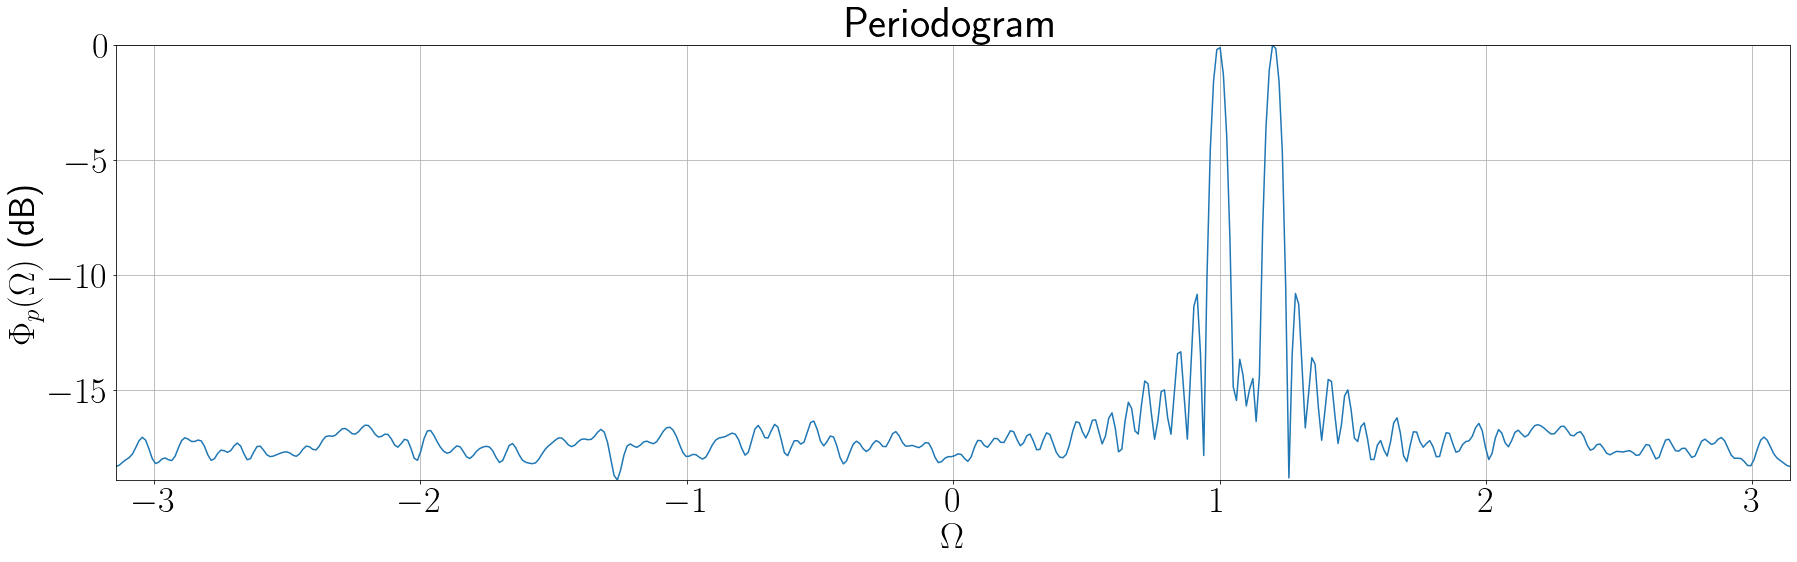

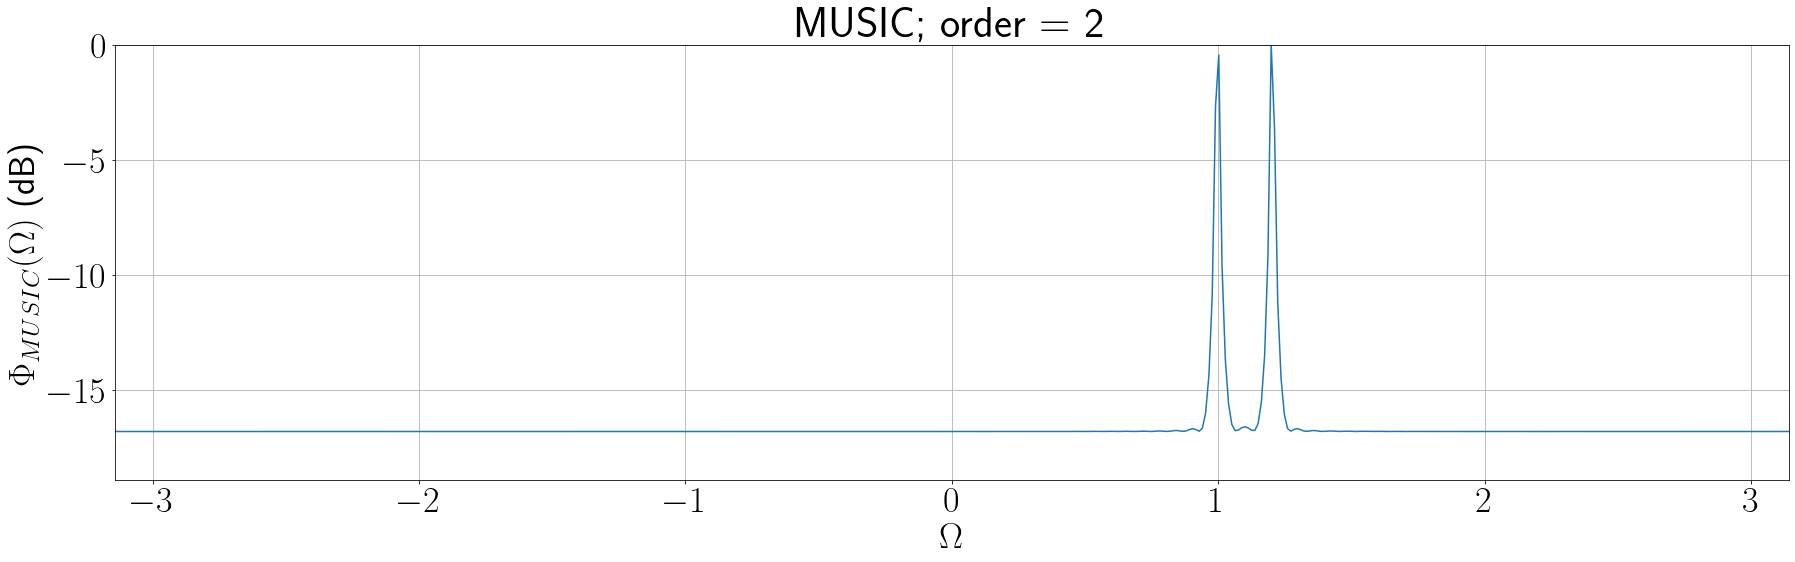

In [8]:
# get min value for equally scaling all plots 

min_val = np.min( psd_per_average )
min_val = 10 * np.log10( min_val )

# plot psds
plt.figure()    

plt.plot(Ome, 10*np.log10( psd_per_average ) )    
plt.grid(True)
plt.title('Periodogram')
plt.axis([- np.pi, np.pi, min_val, 0])
plt.xlabel('$\Omega$')   
plt.ylabel('$\Phi_p(\Omega)$ (dB)')


plt.figure()
plt.plot(Ome,  10*np.log10( psd_music_average ) )    
plt.grid(True) 
plt.title('MUSIC; order = '+str(n))
plt.axis([- np.pi, np.pi, min_val, 0])
plt.xlabel('$\Omega$')
plt.ylabel('$\Phi_{MUSIC}(\Omega)$ (dB)')